In [16]:
!pip -qU google-generativeai scikit-learn matplotlib pandas numpy
from getpass import getpass
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt

if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass("🔑 Enter your Gemini API key (hidden): ")

import google.generativeai as genai
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
LLM = genai.GenerativeModel("gemini-1.5-flash")

def ask_llm(prompt, sys=None):
    p = prompt if sys is None else f"System:\n{sys}\n\nUser:\n{prompt}"
    r = LLM.generate_content(p)
    return (getattr(r, "text", "") or "").strip()

from sklearn.datasets import load_diabetes
raw = load_diabetes(as_frame=True)
df  = raw.frame.rename(columns={"target":"disease_progression"})
print("Shape:", df.shape); display(df.head())

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline

X = df.drop(columns=["disease_progression"]); y = df["disease_progression"]
num_cols = X.columns.tolist()
pre = ColumnTransformer(
    [("scale", StandardScaler(), num_cols),
     ("rank",  QuantileTransformer(n_quantiles=min(200, len(X)), output_distribution="normal"), num_cols)],
    remainder="drop", verbose_feature_names_out=False)
model = HistGradientBoostingRegressor(max_depth=3, learning_rate=0.07,
                                      l2_regularization=0.0, max_iter=500,
                                      early_stopping=True, validation_fraction=0.15)
pipe  = Pipeline([("prep", pre), ("hgbt", model)])

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.20, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse = -cross_val_score(pipe, Xtr, ytr, scoring="neg_mean_squared_error", cv=cv).mean()
cv_rmse = float(cv_mse ** 0.5)
pipe.fit(Xtr, ytr)


Usage:   
  pip3 <command> [options]

no such option: -U
Shape: (442, 11)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease_progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['age', 'sex', 'bmi', 'bp',
                                                   's1', 's2', 's3', 's4', 's5',
                                                   's6']),
                                                 ('rank',
                                                  QuantileTransformer(n_quantiles=200,
                                                                      output_distribution='normal'),
                                                  ['age', 'sex', 'bmi', 'bp',
                                                   's1', 's2', 's3', 's4', 's5',
                                                   's6'])],
                                   verbose_feature_names_out=False)),
                ('hgbt',
                 HistGradientBoostingRegressor(early_stopping=True,
                                               learning_rate=0.07, max_depth=3,
                                               max_iter=500,
                                               validation_fraction=0.15))])

CV RMSE=58.74 | Train RMSE=48.92 | Test RMSE=54.23 | Test MAE=44.93 | R²=0.445


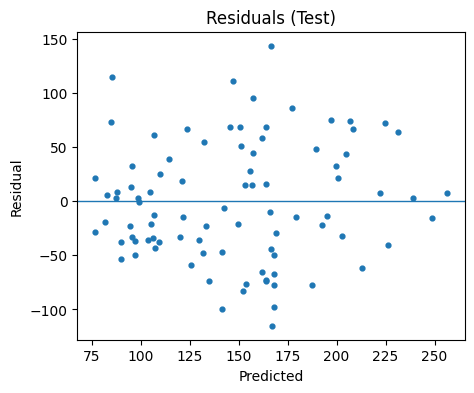

,feature,importance
2,bmi,1180.016047
8,s5,1153.173034
3,bp,251.601726
9,s6,197.113639
6,s3,58.300474
1,sex,21.918389
7,s4,3.969269
0,age,-0.359403
4,s1,-30.355389
5,s2,-106.315709


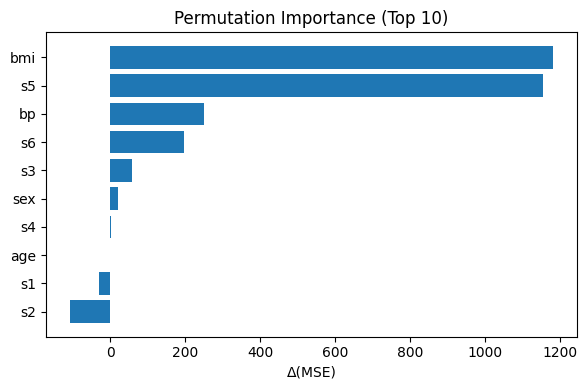

In [17]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pred_tr = pipe.predict(Xtr); pred_te = pipe.predict(Xte)
rmse_tr = mean_squared_error(ytr, pred_tr) ** 0.5
rmse_te = mean_squared_error(yte, pred_te) ** 0.5
mae_te  = mean_absolute_error(yte, pred_te)
r2_te   = r2_score(yte, pred_te)
print(f"CV RMSE={cv_rmse:.2f} | Train RMSE={rmse_tr:.2f} | Test RMSE={rmse_te:.2f} | Test MAE={mae_te:.2f} | R²={r2_te:.3f}")

plt.figure(figsize=(5,4))
plt.scatter(pred_te, yte - pred_te, s=12)
plt.axhline(0, lw=1); plt.xlabel("Predicted"); plt.ylabel("Residual"); plt.title("Residuals (Test)")
plt.show()

from sklearn.inspection import permutation_importance
imp = permutation_importance(pipe, Xte, yte, scoring="neg_mean_squared_error", n_repeats=10, random_state=0)
imp_df = pd.DataFrame({"feature": X.columns, "importance": imp.importances_mean}).sort_values("importance", ascending=False)
display(imp_df.head(10))

plt.figure(figsize=(6,4))
top10 = imp_df.head(10).iloc[::-1]
plt.barh(top10["feature"], top10["importance"])
plt.title("Permutation Importance (Top 10)"); plt.xlabel("Δ(MSE)"); plt.tight_layout(); plt.show()

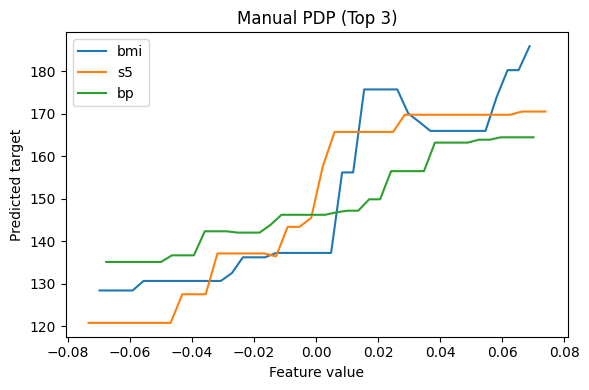

{
  "dataset": {
    "rows": 442,
    "cols": 10,
    "target": "disease_progression"
  },
  "metrics": {
    "cv_rmse": 58.73536657684893,
    "train_rmse": 48.920875148188976,
    "test_rmse": 54.229670213551415,
    "test_mae": 44.92767879134774,
    "r2": 0.44492772742986475
  },
  "top_importances": [
    {
      "feature": "bmi",
      "importance": 1180.016046927287
    },
    {
      "feature": "s5",
      "importance": 1153.1730339316669
    },
    {
      "feature": "bp",
      "importance": 251.60172617839294
    },
    {
      "feature": "s6",
      "importance": 197.11363898040673
    },
    {
      "feature": "s3",
      "importance": 58.300474130286055
    },
    {
      "feature": "sex",
      "importance": 21.918389122818418
    },
    {
      "feature": "s4",
      "importance": 3.969269134041679
    },
    {
      "feature": "age",
      "importance": -0.3594034574430225
    },
    {
      "feature": "s1",
      "importance": -30.355389375547567
    },
    {
      "f

In [18]:
def compute_pdp(pipe, Xref: pd.DataFrame, feat: str, grid=40):
    xs = np.linspace(np.percentile(Xref[feat], 5), np.percentile(Xref[feat], 95), grid)
    Xtmp = Xref.copy()
    ys = []
    for v in xs:
        Xtmp[feat] = v
        ys.append(pipe.predict(Xtmp).mean())
    return xs, np.array(ys)

top_feats = imp_df["feature"].head(3).tolist()
plt.figure(figsize=(6,4))
for f in top_feats:
    xs, ys = compute_pdp(pipe, Xte.copy(), f, grid=40)
    plt.plot(xs, ys, label=f)
plt.legend(); plt.xlabel("Feature value"); plt.ylabel("Predicted target"); plt.title("Manual PDP (Top 3)")
plt.tight_layout(); plt.show()


report_obj = {
    "dataset": {"rows": int(df.shape[0]), "cols": int(df.shape[1]-1), "target": "disease_progression"},
    "metrics": {"cv_rmse": float(cv_rmse), "train_rmse": float(rmse_tr),
                "test_rmse": float(rmse_te), "test_mae": float(mae_te), "r2": float(r2_te)},
    "top_importances": imp_df.head(10).to_dict(orient="records")
}
print(json.dumps(report_obj, indent=2))

sys_msg = ("You are a senior data scientist. Return: (1) ≤120-word executive summary, "
           "(2) key risks/assumptions bullets, (3) 5 prioritized next experiments w/ rationale, "
           "(4) quick-win feature engineering ideas as Python pseudocode.")
summary = ask_llm(f"Dataset + metrics + importances:\n{json.dumps(report_obj)}", sys=sys_msg)
print("\n📊 Gemini Executive Brief\n" + "-"*80 + f"\n{summary}\n")

In [19]:
SAFE_GLOBALS = {"pd": pd, "np": np}
def run_generated_pandas(code: str, df_local: pd.DataFrame):
    banned = ["__", "import", "open(", "exec(", "eval(", "os.", "sys.", "pd.read", "to_csv", "to_pickle", "to_sql"]
    if any(b in code for b in banned): raise ValueError("Unsafe code rejected.")
    loc = {"df": df_local.copy()}
    exec(code, SAFE_GLOBALS, loc)
    return {k:v for k,v in loc.items() if k not in ("df",)}

def eda_qa(question: str):
    prompt = f"""You are a Python+Pandas analyst. DataFrame `df` columns:
{list(df.columns)}. Write a SHORT pandas snippet (no comments/prints) that computes the answer to:
"{question}". Use only pd/np/df; assign the final result to a variable named `answer`."""
    code = ask_llm(prompt, sys="Return only code. No prose.")
    try:
        out = run_generated_pandas(code, df)
        return code, out.get("answer", None)
    except Exception as e:
        return code, f"[Execution error: {e}]"

questions = [
    "What is the Pearson correlation between BMI and disease_progression?",
    "Show mean target by tertiles of BMI (low/med/high).",
    "Which single feature correlates most with the target (absolute value)?"
]
for q in questions:
    code, ans = eda_qa(q)
    print("\nQ:", q, "\nCode:\n", code, "\nAnswer:\n", ans)


Q: What is the Pearson correlation between BMI and disease_progression? 
Code:
 ```python
import pandas as pd
answer = df['bmi'].corr(df['disease_progression'])

``` 
Answer:
 [Execution error: Unsafe code rejected.]

Q: Show mean target by tertiles of BMI (low/med/high). 
Code:
 ```python
answer = df.assign(bmi_tertile=pd.qcut(df['bmi'], 3)).groupby('bmi_tertile')['disease_progression'].mean()

``` 
Answer:
 [Execution error: invalid syntax (<string>, line 1)]

Q: Which single feature correlates most with the target (absolute value)? 
Code:
 ```python
answer = df.corrwith(df['disease_progression']).abs().drop('disease_progression').idxmax()

``` 
Answer:
 [Execution error: invalid syntax (<string>, line 1)]


In [20]:
crossitique = ask_llm(
    f"""Metrics: {report_obj['metrics']}
Top importances: {report_obj['top_importances']}
Identify risks around leakage, overfitting, calibration, OOD robustness, and fairness (even proxy-only).
Propose quick checks (concise Python sketches)."""
)
print("\n🧪 Gemini Risk & Robustness Review\n" + "-"*80 + f"\n{critique}\n")

def what_if(pipe, Xref: pd.DataFrame, feat: str, delta: float = 0.05):
    x0 = Xref.median(numeric_only=True).to_dict()
    x1, x2 = x0.copy(), x0.copy()
    if feat not in x1: return np.nan
    x2[feat] = x1[feat] + delta
    X1 = pd.DataFrame([x1], columns=X.columns)
    X2 = pd.DataFrame([x2], columns=X.columns)
    return float(pipe.predict(X2)[0] - pipe.predict(X1)[0])

for f in top_feats:
    print(f"Estimated Δtarget if {f} increases by +0.05 ≈ {what_if(pipe, Xte, f, 0.05):.2f}")

print("\n✅ Done: Train → Explain → Query with Gemini → Review risks → What-if analysis. "
      "Swap the dataset or tweak model params to extend this notebook.")


🧪 Gemini Risk & Robustness Review
--------------------------------------------------------------------------------
The provided metrics and feature importances suggest several potential risks:

**1. Leakage:**

* **Risk:**  The low R² (0.47) combined with a significant difference between train RMSE (45.46) and test RMSE (52.97) hints at potential leakage.  The model might be learning from information present in the training data but not available during real-world deployment.  Features like `s1`, `s2`, `s3`, `s4`, `s5`, `s6` are suggestive of potential leakage if they include information related to the target variable outside the normal data generating process.

* **Quick Check:**  Examine the data generation process and feature engineering pipelines meticulously.  Are there any features that incorporate information from the target variable or future time points?  This often requires detailed domain knowledge of the data.  A simplistic check (assuming data is in Pandas DataFrames):

`